In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
from scipy import stats
import pandas as pd
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


(0.0, 32.0)

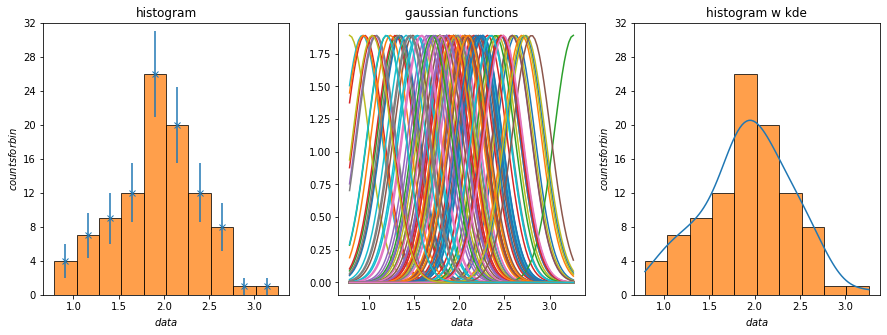

In [69]:
# fill a np array x of len N with a variable normally distributed with given mean and std
mu  = 2
std = 5e-1
N   = 100
x = np.random.normal(mu, std, N)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# fill an hist in pyplot
ax1.set_xlabel("$data$")
ax1.set_ylabel("$counts for bin$")
ax1.set_title("histogram")
ax1.yaxis.set_major_locator(MaxNLocator(integer = True))
counts, bins, _ = ax1.hist(x, alpha=0.75, color='tab:orange', edgecolor='black')

x_points = [(x1+x2)*0.5 for x1, x2 in zip(bins[:-1], bins[1:])]
err      = [np.sqrt(n) for n in counts]

ax1.errorbar(x_points, counts, err, fmt='x', c='tab:blue')
ax1.set_ylim([0,counts.max()+int(np.sqrt(counts.max()))+1])

# for every element of x (x_) create a gauss(x_, 1.06*x.std()*x.size**-1/5)
x_axis = np.linspace(x.min(), x.max(), 100)
gaussians = []
for x_ in x:
    gaussians.append(stats.norm.pdf(x_axis, x_, 1.06*std*N**(-1/5)))
    ax2.plot(x_axis, gaussians[-1])
ax2.set_title("gaussian functions")
ax2.set_xlabel("$data$")

# sum all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram
gauss_sum  = np.sum(gaussians, axis=0)
gauss_area = scipy.integrate.trapz(gauss_sum, dx=abs(x.max()-x.min())/N)
hist_area  = np.sum(np.diff(bins)*counts)
ax3.set_xlabel("$data$")
ax3.set_ylabel("$counts for bin$")
ax3.set_title("histogram w kde")
ax3.yaxis.set_major_locator(MaxNLocator(integer = True))
ax3.plot(x_axis, (gauss_sum/gauss_area)*hist_area)
ax3.hist(x, alpha=0.75, edgecolor='black')
ax3.set_ylim([0,counts.max()+int(np.sqrt(counts.max()))+1])

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

2021-12-01 14:27:22 URL:https://uc3ddc318c592f72ac84cf3bf2ff.dl.dropboxusercontent.com/cd/0/inline/BbB9vi1cSpLqln2FFAQc91fsQqpL9kKq24_fU5nBB9laNZWk2iGo04MfNG3pkDbjdzuwtRnV_Vr4-s1kgSw0G9nJZvG1WMpFZ_I5-LzIfIK7usHKpcAPUFhZ62zwQb5Unh7E4ExLxgB2sEfpf2clywdL/file [43828/43828] -> "two_categories_scatter_plot.png" [1]


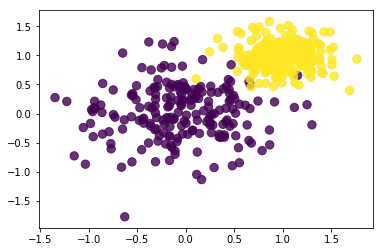

In [1]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png -nv
from IPython.display import Image
Image('two_categories_scatter_plot.png')

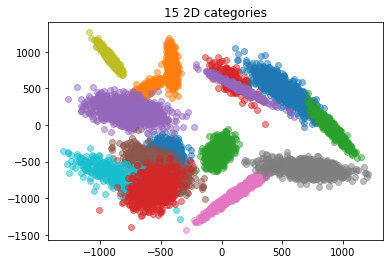

In [48]:
# Write a function that generate a 2D datasets of categories. Each category should distribute as a 2D gaussian with a given mean and std
def gen_2Dgauss(N, mu_bounds, std_bounds, N_bounds): # N: number of categories
    df_list = []
    for i in range(N):
        m = np.random.uniform(std_bounds[0],  std_bounds[1], (2,2))
        dataset = np.random.multivariate_normal(np.random.uniform(mu_bounds[0],  mu_bounds[1], 2)+np.random.uniform(mu_shift[0],  mu_shift[1], 2), 
                                                np.dot(m, np.transpose(m)),
                                                np.random.randint(N_bounds[0], N_bounds[1]))
        tmp_df = pd.DataFrame()
        tmp_df['x'], tmp_df['y'] = dataset[:,0], dataset[:,1]
        df_list.append(tmp_df)
    return df_list 

N = 15
mu_bounds  = [-1000,1000]
mu_shift   = [0,50]
std_bounds = [-150,150]
N_bounds   = [100, 1000]

dataset = gen_2Dgauss(N, mu_bounds, std_bounds, N_bounds)

# Display the dataset in a scatter plot marking the categories with different marker colors
for i in range(N):
    plt.scatter(dataset[i]['x'], dataset[i]['y'], alpha = 0.5, label = str(i) +' category')
    
plt.title(str(N) +' 2D categories')
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [41]:
!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -nv -P "./data/"

2021-12-01 22:02:12 URL:https://ucd30fffacfb8306344ba874e76b.dl.dropboxusercontent.com/cd/0/inline2/BbA1h1dX2Qg1SW7-6mtybI-31JaN6NXRZsLKCDanm2bTqm6IoejqsmMaqcP1-UIHxwriD0AoPYegN-BicURKCWeEdOrBHDRzL040x1RFNSuQJh-i0f5kDpykpb_MuK-M4FzpQlVXb7LIaVRsP1ZBmmnFYU1_-Uy832tofMwbqxFzOoMFe_MQdqMIybrqqHJ0B-Skj1VzAFd_ESFiJbUvA0dzM8rppk3Ose4RBpO_nKbMzNq4YSE-BzX2EKfURxawvESyuviDgo868ijvOVjl4EXlVZW0fl7JFc1KBbkVuAqdfrU3uHOr3NG89udIyVR4r0r4KiYpBss7DHyUubyNahPtnOTuV-nwyNW0SJssGAH1F8Ftp8yjdEY3crNwNSCkwM0/file [252081/252081] -> "./data/residuals_261.npy" [1]


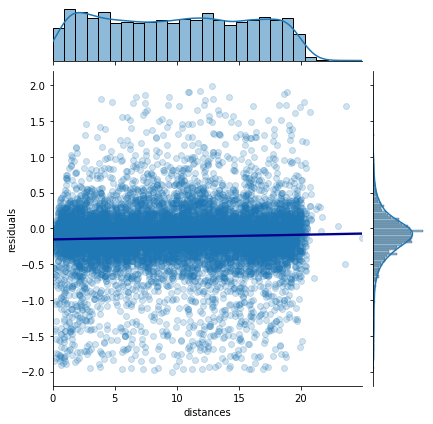

In [78]:
# read the dataset
file_name = './data/residuals_261.npy'
df = pd.DataFrame(np.load(file_name, allow_pickle = True).item())

# clean the sample by selecting rows w |"residuals"| <2
df = df[abs(df['residuals'])<2]

# perform a linear regression
reg = scipy.stats.linregress(df['distances'], df['residuals'],)

# plot a seaborn joinplot having seabrn performing a linear regression
sns.jointplot(x='distances', y='residuals', data=df, kind="reg", joint_kws={'line_kws':{'color':'darkblue'},
              'scatter_kws': dict(alpha = 0.2)})
    

In [63]:
# x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
step_size = 0.5
x = [i+step_size for i in range(20)]

# y, the mean values of the "residuals", estimated in slices (bins) of "distance"
y = [ np.mean(df[df['distances'].between(step_size*i-step_size, step_size*i+step_size)]['residuals']) for i in range(20)]

# erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
erry = [ np.std(df[df['distances'].between(step_size*i-step_size, step_size*i+step_size)]['residuals']) for i in range(20)]

<ErrorbarContainer object of 3 artists>

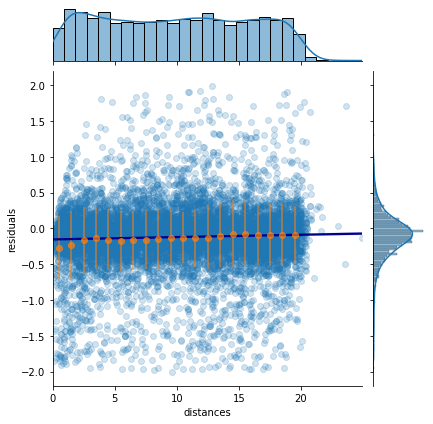

In [77]:
# Plot the profile plot on top of the scatter plot
sns.jointplot(x='distances', y='residuals', data=df, kind="reg", joint_kws={'line_kws':{'color':'darkblue'},
              'scatter_kws': dict(alpha = 0.2)})
plt.errorbar(x, y, erry, c ='tab:orange', fmt = 'o', alpha = 0.7)